In [8]:
## IMPORT MODULES
import numpy as np
import scipy
import scipy.signal as signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pywt
import wfdb
import math
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from skimage.restoration import denoise_wavelet
from data_processing import *
mpl.rcParams['figure.dpi'] = 100

In [9]:
## SELECTION OF STUDY (FEAS 1, FEAS 2, TRIAL)
## OPEN RELEVANT SPREADSHEET WITH DATA
## COUNT AND STORE RELEVANT ECG NUMBERS WITH APPROPRIATE TAGS


df_tags_ecg = pd.read_csv(r"Data\\feas2\\rec_data_anon.csv")
df_tags_pt = pd.read_csv(r"Data\\feas2\\pt_data_anon.csv")
ar_tags_ecg = np.array(pd.DataFrame(df_tags_ecg))
ar_tags_ecg = ar_tags_ecg[:, np.concatenate(([0,44], range(25,37)))]
ar_ecg_AF = np.array(pd.DataFrame(df_tags_ecg, columns=["ptID", "measID", "presAF"]))
ar_ecg_posAF = np.array(pd.DataFrame(df_tags_ecg, columns=["ptID", "measID", "perhapsAF"]))
ar_ecg_tags = np.array(pd.DataFrame(df_tags_ecg, columns=["ptID", "measID", "not_tagged_ign_wide_qrs"]))
ar_ecg_rev = np.array(pd.DataFrame(df_tags_ecg, columns=["ptID", "measID", "measDiag"]))
num = len(df_tags_ecg)


ecg_measID_AF = [i[1] for i in ar_ecg_AF if i[2] == 1]
ecg_ptID_AF = [i[0] for i in ar_ecg_AF if i[2] == 1]
ecg_measID_posAF = [i[1] for i in ar_ecg_posAF if i[2] == 1]
print("num labeled AF:",len(ecg_measID_AF),"\nnum possibly AF:",len(ecg_measID_posAF))
print(ecg_measID_AF)

num labeled AF: 16 
num possibly AF: 3687
[3649, 5206, 6517, 6548, 6718, 6722, 7613, 7615, 8924, 10763, 15003, 15004, 15005, 15009, 15026, 15825]


C:\Users\docto\AppData\Local\Temp\ipykernel_3756\2392797125.py:6: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tags_ecg = pd.read_csv(r"Data\\feas2\\rec_data_anon.csv")


In [10]:
sep_line = "------------------------"
ecg_ptID_rev = [i[0] for i in ar_ecg_rev if i[2]!=6]
ecg_measID_rev = [i[1] for i in ar_ecg_rev if i[2]!=6]
ptID_rev = [i for i in list(range(1,288)) if i in ecg_ptID_rev]
ptID_notrev = [i for i in list(range(1,288)) if i not in ecg_ptID_rev]
ptID_AF = [i for i in list(range(1,288)) if i in ecg_ptID_AF]

# Patients reviewed
print("Patients reviewed: ", len(ptID_rev)) 
print("Patients not reviewed: ", len(ptID_notrev)) 
print(sep_line)

# ECGs tagged
print("ECGs tagged: ", len(ecg_measID_rev))
print("ECGs not tagged: ", num-len(ecg_measID_rev))
print(sep_line)

# ECGs tagged per patient
print("Avg ECGs tagged per reviewed patient: ", len(ecg_measID_rev)/len(ptID_rev))
print(sep_line)

# Tags for reviewed patients without AF
ar_ecg_rev_noAF = [i for i in ar_tags_ecg if i[0] not in ptID_AF]



Patients reviewed:  133
Patients not reviewed:  154
------------------------
ECGs tagged:  1241
ECGs not tagged:  22012
------------------------
Avg ECGs tagged per reviewed patient:  9.330827067669173
------------------------


In [11]:
## SELECTION OF ECG WITHIN STUDY
## VISUALISATION

measID_num = 1343
# 1343 for really noisy data
# 3857 for presentation 

measID_vis = "0"*(6-len(str(measID_num)))+str(measID_num)
folder_vis = "0"*(3-len(str(measID_num//1000)))+str(measID_num//1000)+"0"*3
record = wfdb.rdrecord("Data\\ECGs\\feas2\\"+folder_vis+"\\saferF2_"+measID_vis)

In [12]:
## DATA PREPROCESSING (REMOVING GENERAL TREND)
raw_record = np.ndarray.flatten(record.p_signal)
print(len(raw_record))
fs = record.fs

def generate_filter(fs=fs, low_cut=0.6, high_cut=40, N=8):
    sos = signal.butter(N=N, Wn=[low_cut, high_cut], btype='bandpass', analog=False, output='sos', fs=fs)
    return sos

def apply_filters(ECG, sos):
    ECG_filt = signal.sosfilt(sos, ECG)
    return ECG_filt

15200


585.5219773802194


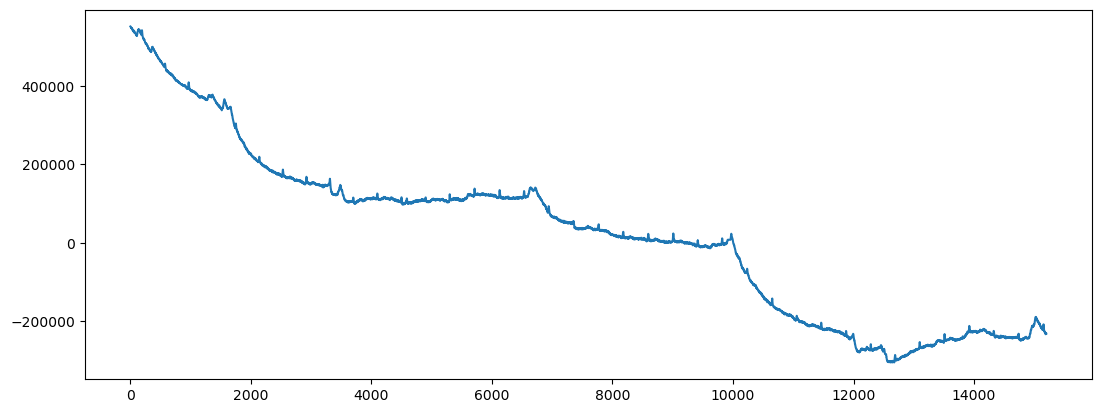

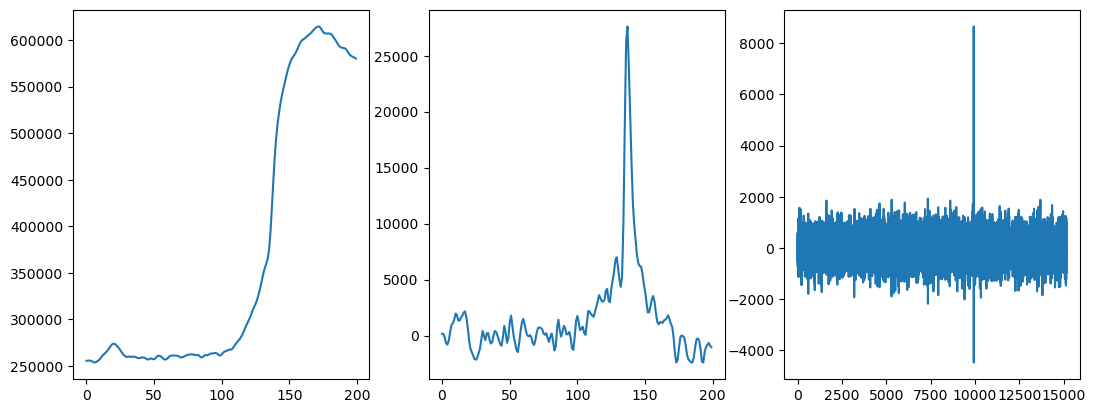

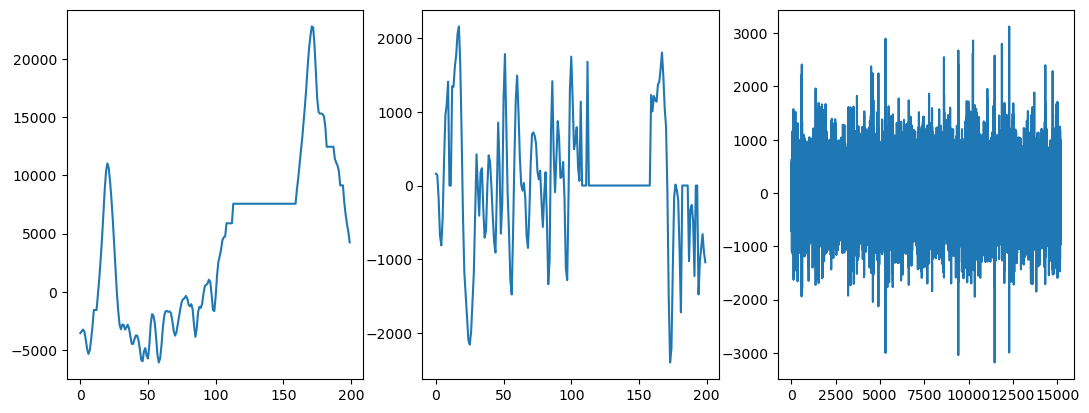

In [13]:
print(np.average(np.abs(np.diff(raw_record))))
avg_diff = np.average(np.abs(np.diff(raw_record)))
attempt_1 = raw_record.copy()

for j, i in enumerate(np.diff(raw_record)):
    if j < 10:
        next
    if i > 3*avg_diff:
        if -np.min(np.diff(raw_record)[j:j+10]) < 0.5*i or i > 6*avg_diff:
            attempt_1[j+1:] -= i
    if i < -3*avg_diff:
        if np.max(np.diff(raw_record)[j-10:j]) < -0.5*i or i < -6*avg_diff:
            attempt_1[j+1:] -= i

plt.figure().set_figwidth(13) 
plt.plot(attempt_1)

plt.figure().set_figwidth(13) 

plt.subplot(1, 3, 1)
plt.plot(raw_record[9800:10000])
plt.subplot(1, 3, 2)
plt.plot(np.diff(raw_record)[9800:10000])
plt.subplot(1, 3, 3)
plt.plot(np.diff(np.diff(raw_record)))

plt.figure().set_figwidth(13) 

plt.subplot(1, 3, 1)
plt.plot(attempt_1[9800:10000])
plt.subplot(1, 3, 2)
plt.plot(np.diff(attempt_1)[9800:10000])
plt.subplot(1, 3, 3)
plt.plot(np.diff(np.diff(attempt_1)))

Text(0.5, 0, 'time (s)')

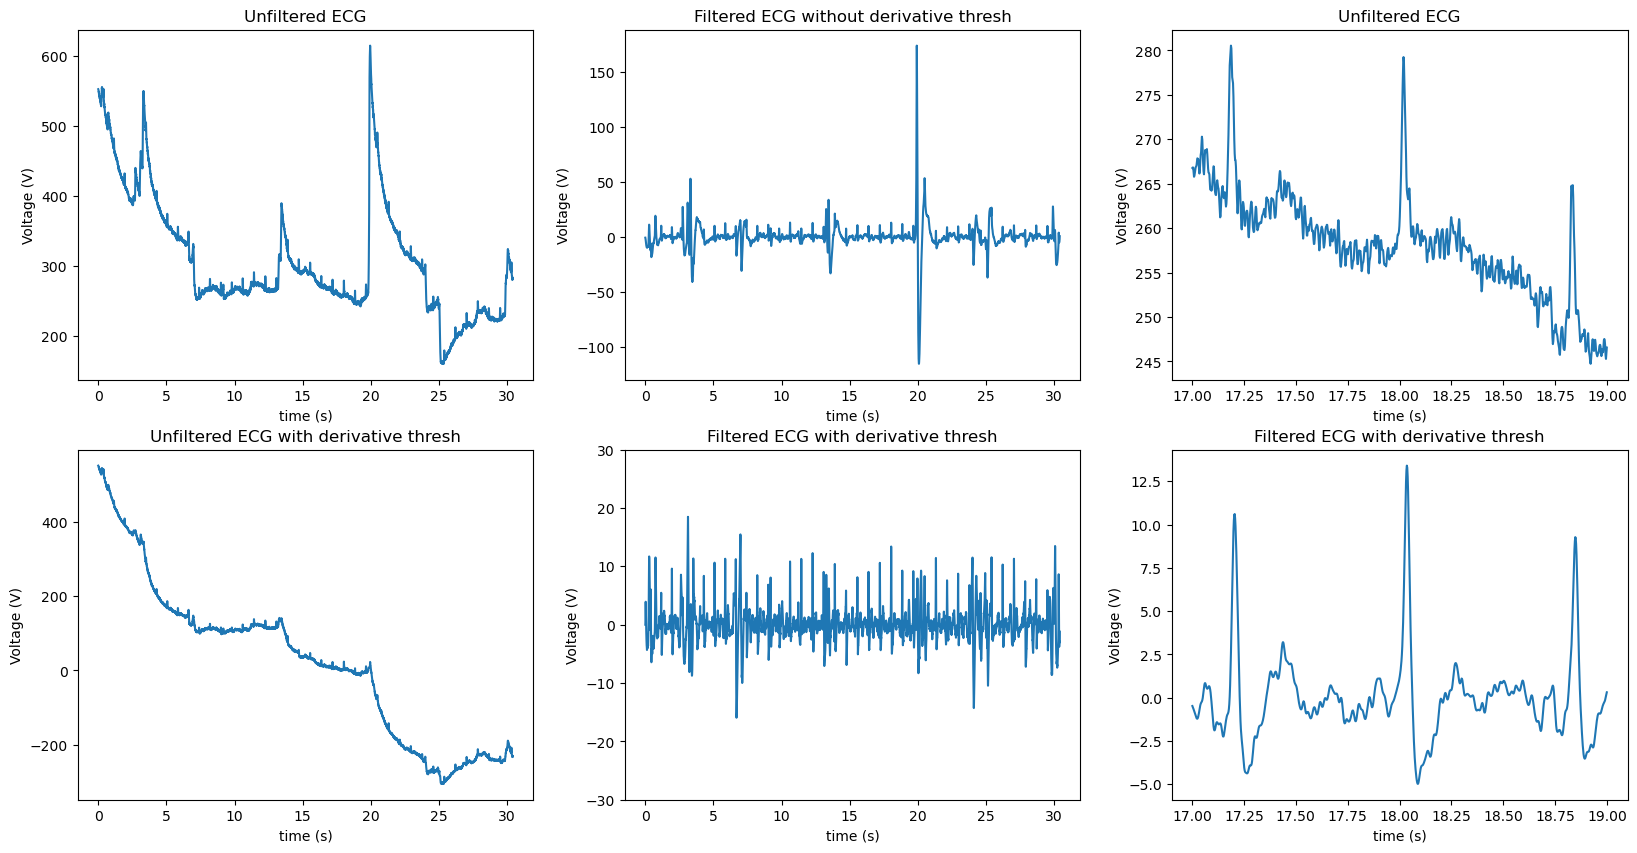

In [14]:
npad = 600

raw_record_deriv = raw_record - np.array([0] + list(raw_record[:-1]))
raw_record_deriv_2 = raw_record_deriv - np.array([0] + list(raw_record_deriv[:-1]))
avg_deriv = np.average(np.abs(raw_record_deriv))

attempt_detrend = raw_record.copy()
for i in range(len(raw_record_deriv)):
    if abs(raw_record_deriv[i]) > avg_deriv*5:
        attempt_detrend[i:] -= raw_record_deriv[i]

trend = denoise_wavelet(attempt_detrend, mode='soft', wavelet_levels=3, wavelet='db4', rescale_sigma='True')

DWTcoeffs = pywt.wavedec(attempt_1, 'sym6')
DWTcoeffs[-1] = np.zeros_like(DWTcoeffs[-1])
DWTcoeffs[-2] = np.zeros_like(DWTcoeffs[-2])
DWTcoeffs[-3] = np.zeros_like(DWTcoeffs[-3])
DWTcoeffs[-4] = np.zeros_like(DWTcoeffs[-4])
DWTcoeffs[-5] = np.zeros_like(DWTcoeffs[-5])
DWTcoeffs[-6] = np.zeros_like(DWTcoeffs[-6])
DWTcoeffs[-7] = np.zeros_like(DWTcoeffs[-7])
# DWTcoeffs[-8] = np.zeros_like(DWTcoeffs[-8])
# DWTcoeffs[-9] = np.zeros_like(DWTcoeffs[-9])
filtered_data_dwt = pywt.waverec(DWTcoeffs,'sym6',mode='symmetric',axis=-1)

attempt_detrend_detrend = attempt_1 - filtered_data_dwt
raw_record_pad = np.concatenate((np.ones(npad)*raw_record[0], raw_record))
raw_record_pad_dt = np.concatenate((np.ones(npad)*attempt_1[0], attempt_1))

sos1 = generate_filter(low_cut=0.6, high_cut=40, N=1)
sos8 = generate_filter(low_cut=0.6, high_cut=40, N=8)

raw_filt1 = apply_filters(raw_record_pad, sos1)
raw_filt1_detrend = apply_filters(attempt_detrend_detrend, sos1)
raw_filt1_dt = apply_filters(raw_record_pad_dt, sos1)
raw_filt8 = apply_filters(raw_record_pad, sos8)
raw_filt8_detrend = apply_filters(attempt_detrend_detrend, sos8)

for _ in range(4):
    raw_filt1 = apply_filters(raw_filt1, sos1)
    raw_filt1_dt = apply_filters(raw_filt1_dt, sos1)
    raw_filt1_detrend = apply_filters(raw_filt1_detrend, sos1)

startv = 8500
endv = 9500
x = np.linspace(0,30.4,15200)
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.plot(x, raw_record/1000)
plt.title('Unfiltered ECG')
plt.ylabel('Voltage (V)')
plt.xlabel('time (s)')
plt.subplot(2,3,2)
plt.plot(x, raw_filt1[npad:]/1000)
plt.title('Filtered ECG without derivative thresh')
plt.ylabel('Voltage (V)')
plt.xlabel('time (s)')
plt.subplot(2,3,3)
plt.plot(x[startv:endv], raw_record[startv:endv]/1000)
plt.title('Unfiltered ECG')
plt.ylabel('Voltage (V)')
plt.xlabel('time (s)')
plt.subplot(2,3,4)
plt.plot(x, attempt_1/1000)
plt.title('Unfiltered ECG with derivative thresh')
plt.ylabel('Voltage (V)')
plt.xlabel('time (s)')
plt.subplot(2,3,5)
plt.plot(x, raw_filt1_detrend/1000)
plt.ylim(-30,30)
plt.title('Filtered ECG with derivative thresh')
plt.ylabel('Voltage (V)')
plt.xlabel('time (s)')
plt.subplot(2,3,6)
plt.plot(x[startv:endv], raw_filt1_detrend[startv:endv]/1000)
plt.title('Filtered ECG with derivative thresh')
plt.ylabel('Voltage (V)')
plt.xlabel('time (s)')

# plt.figure().set_figwidth(20) 
# plt.subplot(1, 2, 1)
# plt.plot(attempt_detrend_detrend)
# plt.subplot(1, 2, 2)
# plt.plot(attempt_detrend_detrend[startv-npad:endv-npad])
# plt.show()
# plt.figure().set_figwidth(20) 
# plt.subplot(1, 2, 1)
# plt.plot(raw_record_detrend)
# plt.subplot(1, 2, 2)
# plt.plot(raw_record_detrend[startv-npad:endv-npad])
# plt.show()
# plt.figure().set_figwidth(20) 
# plt.subplot(1, 3, 1)
# plt.plot(raw_filt1[npad:])
# plt.subplot(1, 3, 2)
# plt.plot(raw_filt1_detrend)
# plt.subplot(1, 3, 3)
# plt.plot(raw_filt1[startv:endv])
# plt.plot(raw_filt1_detrend[startv-npad: endv-npad])
# plt.legend(('Wavelet', 'Derivative'))
# plt.show()
# plt.figure().set_figwidth(20) 
# plt.subplot(1, 3, 1)
# plt.plot(raw_filt8[npad:])
# plt.subplot(1, 3, 2)
# plt.plot(raw_filt8_detrend)
# plt.subplot(1, 3, 3)
# plt.plot(raw_filt8[startv:endv])
# plt.plot(raw_filt8_detrend[startv-npad: endv-npad])
# plt.legend(('Wavelet', 'Derivative'))

In [15]:
DWTcoeffs = pywt.wavedec(raw_record, 'db4')
DWTcoeffs[-1] = np.zeros_like(DWTcoeffs[-1])
DWTcoeffs[-2] = np.zeros_like(DWTcoeffs[-2])
DWTcoeffs[-3] = np.zeros_like(DWTcoeffs[-3])
DWTcoeffs[-4] = np.zeros_like(DWTcoeffs[-4])
DWTcoeffs[-5] = np.zeros_like(DWTcoeffs[-5])
DWTcoeffs[-6] = np.zeros_like(DWTcoeffs[-6])
DWTcoeffs[-7] = np.zeros_like(DWTcoeffs[-7])
# DWTcoeffs[-8] = np.zeros_like(DWTcoeffs[-8])
# DWTcoeffs[-9] = np.zeros_like(DWTcoeffs[-9])
filtered_data_dwt = pywt.waverec(DWTcoeffs,'db4',mode='symmetric',axis=-1)

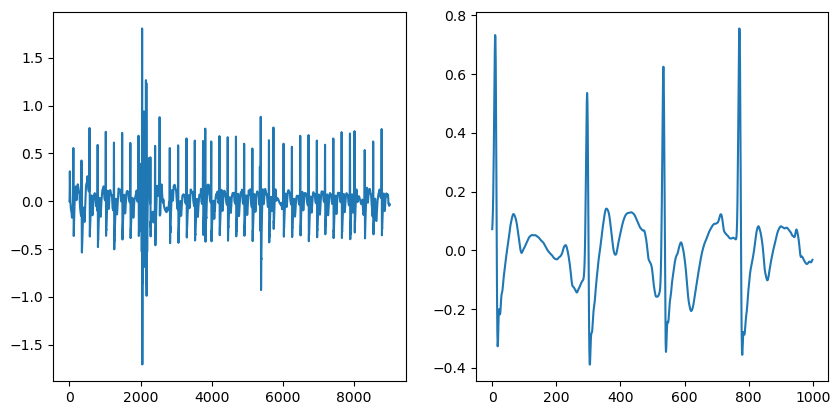

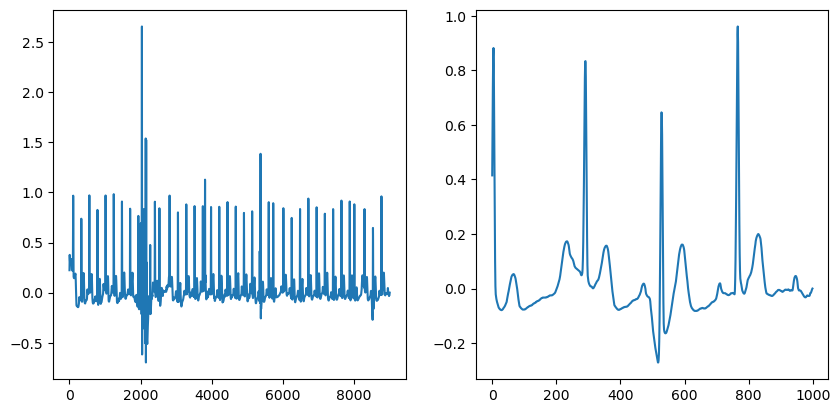

In [16]:
physionet_sample = wfdb.rdrecord("Physionet challenge\\physionet-challenge-2017\\training2017\\A00061")
physionet_sample_signal = np.ndarray.flatten(physionet_sample.p_signal)
fs = physionet_sample.fs

sos = generate_filter(fs, low_cut=0.6, high_cut=40)
physionet_sample_signal_filtered = apply_filters(physionet_sample_signal, sos)

startv = 8000
endv = 9000

plt.figure().set_figwidth(10) 
plt.subplot(1, 2, 1)
plt.plot(physionet_sample_signal_filtered)
plt.subplot(1, 2, 2)
plt.plot(physionet_sample_signal_filtered[startv:endv])
plt.show()
plt.figure().set_figwidth(10) 
plt.subplot(1, 2, 1)
plt.plot(physionet_sample_signal)
plt.subplot(1, 2, 2)
plt.plot(physionet_sample_signal[startv:endv])
plt.show()

In [17]:
tags = df_tags_ecg.iloc[3648]

print(list(tags.iloc[25:37]))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
ar_tags_ecg = np.array(pd.DataFrame(df_tags_ecg))

def extract_measIDs(ar_tags_ecg, ptID_num):
    ptID_measIDs = []
    i = [j[0] for j in ar_tags_ecg].index(ptID_num)
    print(i)
    while ar_tags_ecg[i][0] == ptID_num:
        ptID_measIDs.append(ar_tags_ecg[i][-1])
        i += 1
    return ptID_measIDs


print(len(extract_measIDs(ar_tags_ecg, 20)))

1565
82


In [19]:
key_feas2 = pd.read_csv(r"Data\\feas2\\rec_data_anon_diag_key.csv")

print(key_feas2)

                                                 txt  num
0                                   AF >= 30 seconds    1
1  Cannot exclude AF>=30 seconds, VT or 2/3 degre...    2
2  No AF >= 30 secs, VT or 2/3 degree heart block...    3
3                                       Poor quality    4
4                                  Screening Failure    5
5                                          Undecided    6
6                     Disagreement between reviewers   -1


In [20]:
ecg = ecg()

In [21]:
af_ecgs_2 = ecg.store_ecg_tags(study = 'feas2', tag = 'AF')
af_ecgs_1 = ecg.store_ecg_tags(study = 'feas1', tag = 'AF')
# af_ecgs = af_ecgs_1 + af_ecgs_2
noaf_ecgs = ecg.store_ecg_tags(study = 'feas2', tag = 'noAF')
undec_ecgs = ecg.store_ecg_tags(study = 'feas2', tag = 'undecided')

print(len(af_ecgs_2), len(af_ecgs_1))

14 605


In [22]:
measIDs_noAF = ecg.extract_measIDs(tag='noAF')

pt_ecg_classifier = []
i = 0
while len(pt_ecg_classifier) < 12:
    pt = ecg.extract_measID_pt(measIDs_noAF[i])
    if pt not in ptID_AF and pt not in pt_ecg_classifier:
        pt_ecg_classifier.append(ecg.extract_measID_pt(measIDs_noAF[i]))
    i += 1
pt_pt_classifier = [i for i in list(range(1,288)) if i not in pt_ecg_classifier]

meas_train_noAF = []
for i in pt_ecg_classifier:
    meas_train_noAF += ecg.extract_pt_measIDs(i)

af_ecgs = af_ecgs_1
noaf_ecgs = ecg.store_ecg_tags(measIDs=meas_train_noAF)

# ecg_measID_rev


In [23]:
akdca = undec_ecgs[120]
print([1 for i in akdca if math.isnan(i)])

print(len(af_ecgs))

[]
605


In [24]:
n_undec = 300
# x = np.array(af_ecgs + noaf_ecgs + undec_ecgs[:n_undec])
# y = np.array([1]*len(af_ecgs) + [0]*len(noaf_ecgs) + [0]*len(undec_ecgs[:n_undec]))

x = np.array(af_ecgs + noaf_ecgs)
y = np.array([1]*len(af_ecgs) + [0]*len(noaf_ecgs))

permutation = np.random.permutation(x.shape[0])
x = x[permutation,:]
y = y[permutation]

print(len(x), sum([i for i in y if i == 1]))

n_train = 1000
x_train = x[0:n_train, :]
x_test = x[n_train:, :]
y_train = y[0: n_train]
y_test = y[n_train:]

print(x[0])

1501 605
[79.    18.85   0.413  0.     0.     0.     1.     1.     0.     0.
  0.     0.     0.     0.     0.   ]


In [25]:
model_lr = LogisticRegression(solver='liblinear', random_state=0)
model_lr.fit(x_train, y_train)

model_svm = svm.SVC(kernel='rbf')
model_svm.fit(x_train, y_train)

model_svm_nu = svm.SVC(kernel='poly')
model_svm_nu.fit(x_train, y_train)

models = [model_lr, model_svm]
print('Done')
# Logistic regression
# Support vector machines
# Simple neural network


Done


In [26]:
print(model_lr.score(x_test, y_test))
print(confusion_matrix(y_test, [round(i[1]) for i in model_lr.predict_proba(x_test)]))
assert len(y_test) == len(x_test)
n = len(y_test)
wrong = []
for i in range(n):
    if y_test[i] != round(model_lr.predict_proba(x_test)[i][1]):
        wrong.append([y_test[i], model_lr.predict_proba(x_test)[i][1]])

print(model_svm.score(x_test, y_test))
print(confusion_matrix(y_test, model_svm.predict(x_test)))
print(model_svm_nu.score(x_test, y_test))
print(confusion_matrix(y_test, model_svm_nu.predict(x_test)))

0.9141716566866267
[[265  37]
 [  6 193]]
0.9181636726546906
[[274  28]
 [ 13 186]]
0.9121756487025948
[[272  30]
 [ 14 185]]


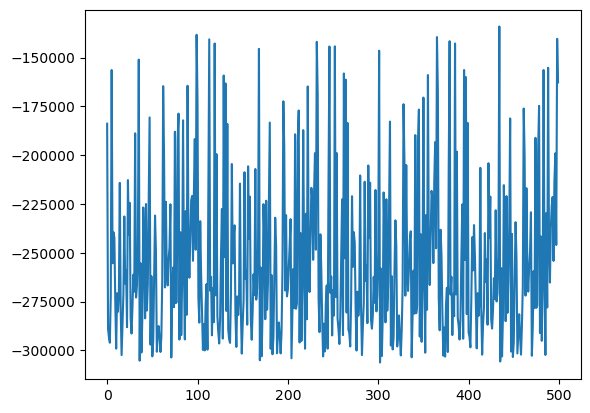

In [27]:

ecg_signal = wfdb.rdsamp("Data\\ECGs\\feas1\\000000\\saferF1_pt000003")
plt.plot([i[0] for i in ecg_signal[0]][8000:8500])

# ecg_signal = wfdb.rdrecord("Data\\ECGs\\feas1\\000000\\saferF1_pt000003")
# plt.plot([i[0] for i in ecg_signal.p_signal][8000:8500])

In [28]:
pt_pt_classifier
n_pt_AF_train = 5
pt_pt_train = []
i = 0
while len(pt_pt_train) < 185:
    pt = pt_pt_classifier[i]
    if pt not in ptID_AF and pt not in pt_pt_train:
        pt_pt_train.append(pt)
    i += 1
print(ptID_AF, ecg_measID_AF)
pt_pt_train += ptID_AF[:n_pt_AF_train] # + [187]
pt_pt_test = [i for i in list(range(1,288)) if (i not in pt_pt_train and i not in ptID_AF)] + ptID_AF[n_pt_AF_train:] 
# + [i for i in ptID_AF[n_pt_AF_train:] if i != 187]
print(len(pt_pt_train), len(pt_pt_test))

[45, 64, 81, 83, 94, 111, 134, 187, 198] [3649, 5206, 6517, 6548, 6718, 6722, 7613, 7615, 8924, 10763, 15003, 15004, 15005, 15009, 15026, 15825]
190 97


In [72]:
assert pt_pt_train[-n_pt_AF_train:] == ptID_AF[:n_pt_AF_train]
pt_train_probs = []

measIDs_probs = []
for i in pt_pt_train:
    measIDs_probs.append(ecg.extract_pt_measIDs(i))

for i in measIDs_probs:
    data = []
    for j in i:
        cdl_tags = ecg.extract_cardiolund_tags(ecg.extract_tags(j))
        if cdl_tags is not None:
            data.append(cdl_tags)
    probs_WHY = list(model_lr.predict_proba(data)[:,1])
    probs_WHY.sort(reverse=True)
    pt_train_probs.append(probs_WHY[::-1])

print(pt_train_probs)


assert pt_pt_test[-len(ptID_AF)+n_pt_AF_train:] == ptID_AF[n_pt_AF_train:]
pt_test_probs = []

measIDs_probs = []
for i in pt_pt_test:
    measIDs_probs.append(ecg.extract_pt_measIDs(i))

for i in measIDs_probs:
    data = []
    for j in i:
        cdl_tags = ecg.extract_cardiolund_tags(ecg.extract_tags(j))
        if cdl_tags is not None:
            data.append(cdl_tags)
    probs_WHY = list(model_lr.predict_proba(data)[:,1])
    probs_WHY.sort(reverse=True)
    pt_test_probs.append(probs_WHY[::-1])

print(pt_test_probs)


[[0.012107903330679822, 0.012372460564642867, 0.012637635938041809, 0.013698758981326914, 0.014116583972163154, 0.014273720964849107, 0.014513067865142865, 0.014853242814780336, 0.015144207217229765, 0.01538325218991859, 0.01571913645861044, 0.01580368989462448, 0.016060574428018667, 0.01623357866149056, 0.016364493847963794, 0.01672096728381578, 0.017054530584255774, 0.017329377495532948, 0.01751007669319276, 0.01755681660419561, 0.017664889286349808, 0.01773427070925356, 0.0178024992479236, 0.017810668145451722, 0.017837520348933197, 0.017863344194163563, 0.018599928017207112, 0.01864884670940869, 0.01876571055941404, 0.018799811327722116, 0.018880398315729987, 0.01919123691940753, 0.019456719201054268, 0.01953396401996725, 0.01972132923617138, 0.020092474013472014, 0.020147851203082504, 0.020589514480556435, 0.020895438823977836, 0.021564844599428156, 0.02159557068336051, 0.021717677280260993, 0.021733409398866303, 0.022632895394086465, 0.022689074491729605, 0.02291668599814799, 0.0

In [74]:
# print(np.shape(np.array(pt_train_probs)), np.shape(np.array(pt_test_probs)))

pt_train_classes = [0]*(len(pt_train_probs)-n_pt_AF_train) + [1]*n_pt_AF_train
pt_test_classes = [0]*(len(pt_test_probs)-len(ptID_AF)+n_pt_AF_train) + [1]*(len(ptID_AF)-n_pt_AF_train)

print(len(pt_train_classes), len(pt_test_classes))

190 97


In [75]:
# x = np.array(pt_train_probs)
# y = np.array(pt_train_classes)
# print(len(x), sum([i for i in y if i == 1]))

# permutation = np.random.permutation(x.shape[0])

# x_train = x[permutation,:]
# y_train = y[permutation]
# x_test = np.array(pt_test_probs)
# y_test = np.array(pt_test_classes)

x_train_pt = pt_train_probs
y_train_pt = pt_train_classes
x_test_pt = pt_test_probs
y_test_pt = pt_test_classes

In [32]:
def arb_val(w, x):
    # return np.sum(np.e**(w[0]*np.log(np.array(x)) - w[1]*np.log(np.array(x))))/len(x)
    return np.dot(w, x)
    

def obj_func(w, x_train, y_train):
    val = 0
    for i, j in zip(x_train, y_train):
        val += arb_val(w, i)*(2*j-1)
    return val

In [33]:
MAP = scipy.optimize.minimize(obj_func, [1]*5, args=(x_train_pt, y_train_pt))

In [34]:
print(MAP.x)

[25701976.50490766 17228977.94983779 13293832.70955198 11073574.53468787
  9511600.35298555]


In [35]:
ar_ecg_AF = list(np.array(pd.DataFrame(df_tags_pt, columns=["noRecs"])))
print(min(ar_ecg_AF), ar_ecg_AF.index(min(ar_ecg_AF)))

[22] 188


In [36]:
model_pt_lr = LogisticRegression(solver='liblinear', random_state=0, class_weight={0:1,1:200})
model_pt_lr.fit(x_train_pt, y_train_pt)

LogisticRegression(class_weight={0: 1, 1: 200}, random_state=0,
                   solver='liblinear')

In [37]:
print(model_pt_lr.score(x_test_pt, y_test_pt))
print(confusion_matrix(y_test_pt, [round(i[1]) for i in model_pt_lr.predict_proba(x_test_pt)]))

for i in range(len(y_test_pt)):
    if model_pt_lr.predict(x_test_pt)[i] != y_test_pt[i] and y_test_pt[i] == 1: ind = i

# wtf_pt = pt_pt_test[ind]
# wtf_ecgs = ecg.extract_pt_measIDs(wtf_pt)

# print(x_test[ind])

0.8144329896907216
[[75 18]
 [ 0  4]]


In [40]:
# inds = []
# for i in range(len(y_test)):
#     if model_pt_lr.predict(x_test_pt)[i] != y_test_pt[i]: inds.append(i)

# wtf_pt_IDs = [pt_pt_test[ind] for ind in inds]
# print(wtf_pt_IDs)
# pt_IDs_shouldhavebeensent = [i for i in ptID_rev if i in pt_pt_test]
# print('Patients that should have been sent: ', len(pt_IDs_shouldhavebeensent))
# print('Patients removed: ', sum([1 for i in pt_IDs_shouldhavebeensent if (i not in wtf_pt_IDs and i not in ptID_AF)]))
# print('Patients added: ', sum([1 for i in wtf_pt_IDs if i not in pt_IDs_shouldhavebeensent]))
# not_sent_to_review = []
# for i in pt_pt_test:
#     if i in wtf_pt_IDs: not_sent_to_review.append(1)


In [41]:
# Additionally do prioritisation over patients
# Apply more methods to determine patient level diagnoses

pt_probs = model_pt_lr.predict_proba(x_test_pt)

In [42]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=[15200,1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=100, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=100, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=100, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=100, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=100, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=100, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=100, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='sigmoid'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [43]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15196, 16)         96        
                                                                 
 max_pooling1d (MaxPooling1  (None, 7549, 16)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 7545, 16)          1296      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3723, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 3719, 16)          1296      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1810, 16)          0

In [44]:
af_measIDs_1 = ecg.extract_measIDs(tag = 'AF', study = 'feas1')
af_measIDs_2 = ecg.extract_measIDs(tag = 'AF', study = 'feas2')
noaf_measIDs_2 = ecg.extract_measIDs(tag = 'noAF', study = 'feas2')
print(len(af_measIDs_1+af_measIDs_2), len(noaf_measIDs_2))
print(af_measIDs_1)

838 758
[4601, 4602, 4603, 4604, 4617, 4618, 4633, 4634, 4635, 4636, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156, 9157, 9158, 9159, 9160, 9162, 9163, 9164, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9693, 9705, 9710, 13184, 13195, 13208, 13245, 13246, 13247, 13248, 13249, 13935, 13936, 19340, 19345, 19350, 19365, 19366, 19371, 19373, 19374, 19377, 19378, 19379, 19380, 19381, 19387, 19388, 19389, 19391, 19392, 19850, 19872, 19877, 19880, 19881, 20039, 20041, 20042, 20044, 20047, 20055, 20056, 20084, 20104, 20105, 20107, 20108, 20111, 20112, 20114, 20115, 20134, 20136, 20137, 21626, 21634, 21638, 23356, 23357, 23358, 23397, 33801, 33802, 33803, 33804, 33806, 33808, 33810, 33815, 33817, 33818, 33819, 33822, 33824, 33825, 33826, 33831, 33832, 33833, 33835, 33836, 33837, 33838, 33840, 33841, 33842, 33843, 33844, 33845, 33846, 33847, 33848, 33849, 33850, 33851, 33852, 35136, 35148, 35155, 35163, 35170, 39734, 39746, 39748, 39750, 39752, 39760, 39769, 39770, 39777, 3

In [45]:
X = []
sos1 = generate_filter(fs, low_cut=0.6, high_cut=40, N=1)
for i in af_measIDs_1:
    measID_vis = '0'*(6-len(str(i)))+str(i)
    if os.path.isfile('Data\\ECGs\\feas1\\afECGs\\saferF1_'+measID_vis+'.hea'):
        X.append(filter_signal(ecg.extract_signal(i, study='feas1'), sos1))
for i in af_measIDs_2:
    X.append(filter_signal(ecg.extract_signal(i, study='feas2'), sos1))
for i in noaf_measIDs_2:
    X.append(filter_signal(ecg.extract_signal(i, study='feas2'), sos1))
y = [1]*len(af_measIDs_1+af_measIDs_2) + [0]*len(noaf_measIDs_2)

In [ ]:
X = np.array(normalise_signals(X))
y = np.array(y)
permutation = np.random.permutation(X.shape[0])
X = X[permutation,:]
y = y[permutation]

print(len(X))

1591


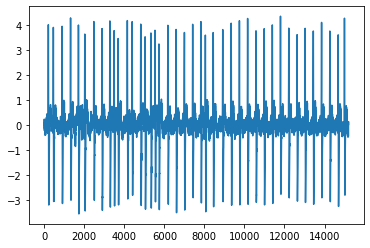

In [ ]:
plt.plot(X[1])

In [ ]:
X_train = X[:1000]
y_train = y[:1000]

X_val = X[1000:1300]
y_val = y[1000:1300]

X_test = X[1300:]
y_test = y[1300:]

In [ ]:
history = cnn.fit(X_train, y_train, epochs=64, 
                    validation_data=(X_val, y_val))

Epoch 1/64
32/32 [==============================] - 20s 562ms/step - loss: 0.6948 - accuracy: 0.5320 - val_loss: 0.6832 - val_accuracy: 0.5367
Epoch 2/64
32/32 [==============================] - 19s 581ms/step - loss: 0.6754 - accuracy: 0.5690 - val_loss: 0.6544 - val_accuracy: 0.6100
Epoch 3/64
32/32 [==============================] - 20s 614ms/step - loss: 0.6505 - accuracy: 0.6170 - val_loss: 0.6340 - val_accuracy: 0.6367
Epoch 4/64
32/32 [==============================] - 20s 611ms/step - loss: 0.6520 - accuracy: 0.6020 - val_loss: 0.6502 - val_accuracy: 0.5200
Epoch 5/64
32/32 [==============================] - 19s 600ms/step - loss: 0.6353 - accuracy: 0.6060 - val_loss: 0.6029 - val_accuracy: 0.6567
Epoch 6/64
32/32 [==============================] - 19s 603ms/step - loss: 0.6185 - accuracy: 0.6390 - val_loss: 0.6267 - val_accuracy: 0.5533
Epoch 7/64
32/32 [==============================] - 19s 603ms/step - loss: 0.6073 - accuracy: 0.6580 - val_loss: 0.5796 - val_accuracy: 0.6900

10/10 - 1s - loss: 0.4026 - accuracy: 0.8316 - 1s/epoch - 115ms/step


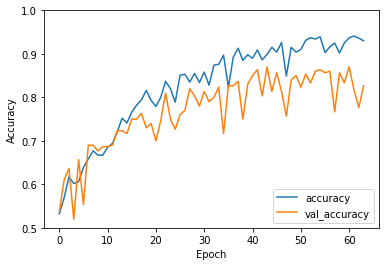

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)

0.831615149974823


In [76]:
rnn = tf.keras.models.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
rnn.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(None,1)))
rnn.add(tf.keras.layers.LSTM(8))
# Add a Dense layer with 10 units.
rnn.add(tf.keras.layers.Dense(1))

rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, None, 32)          4352      
                                                                 
 lstm_11 (LSTM)              (None, 8)                 1312      
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5673 (22.16 KB)
Trainable params: 5673 (22.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [78]:
print(x_train_pt)
print(y_train_pt)

[[0.012107903330679822, 0.012372460564642867, 0.012637635938041809, 0.013698758981326914, 0.014116583972163154, 0.014273720964849107, 0.014513067865142865, 0.014853242814780336, 0.015144207217229765, 0.01538325218991859, 0.01571913645861044, 0.01580368989462448, 0.016060574428018667, 0.01623357866149056, 0.016364493847963794, 0.01672096728381578, 0.017054530584255774, 0.017329377495532948, 0.01751007669319276, 0.01755681660419561, 0.017664889286349808, 0.01773427070925356, 0.0178024992479236, 0.017810668145451722, 0.017837520348933197, 0.017863344194163563, 0.018599928017207112, 0.01864884670940869, 0.01876571055941404, 0.018799811327722116, 0.018880398315729987, 0.01919123691940753, 0.019456719201054268, 0.01953396401996725, 0.01972132923617138, 0.020092474013472014, 0.020147851203082504, 0.020589514480556435, 0.020895438823977836, 0.021564844599428156, 0.02159557068336051, 0.021717677280260993, 0.021733409398866303, 0.022632895394086465, 0.022689074491729605, 0.02291668599814799, 0.0

In [80]:
rnn.fit(np.array([x_train_pt]).T, y_train_pt, epochs = 10000, batch_size = 64)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 190) + inhomogeneous part.

In [70]:
predictions = rnn.predict(x_test_pt)

print(predictions)
print(y_test_pt)

4/4 [==============================] - 0s 2ms/step
[[ 5.1327646e-03]
 [-3.4573674e-04]
 [ 1.7823130e-03]
 [ 2.2736788e-03]
 [ 6.7591995e-02]
 [ 1.0944791e-02]
 [ 2.0787418e-03]
 [ 1.9877106e-02]
 [ 3.0097812e-03]
 [ 2.2854060e-03]
 [ 9.2809200e-03]
 [ 8.3884597e-04]
 [ 2.1009147e-03]
 [ 6.5362453e-04]
 [ 1.9613355e-03]
 [ 1.7549574e-02]
 [ 2.2501200e-03]
 [ 1.9583851e-03]
 [ 8.8817686e-02]
 [ 6.7578644e-02]
 [ 6.7813069e-02]
 [ 6.6921264e-03]
 [ 4.4366121e-03]
 [ 2.0662993e-03]
 [ 1.2495300e-01]
 [ 5.5056363e-01]
 [ 2.5058538e-03]
 [-1.6055295e-01]
 [ 2.2924989e-03]
 [-6.6651404e-04]
 [ 2.2216737e-03]
 [ 3.0286908e-03]
 [ 3.9780140e-04]
 [ 9.9393725e-04]
 [ 8.0413818e-03]
 [ 1.6007423e-03]
 [ 2.1987259e-03]
 [ 2.3470819e-03]
 [-2.5233626e-04]
 [ 1.6989805e-02]
 [-9.5246285e-03]
 [-6.4492226e-03]
 [-1.0658056e-02]
 [ 2.4573803e-03]
 [ 1.4151804e-02]
 [ 1.1442006e-03]
 [ 1.3270405e-01]
 [ 2.0825863e-03]
 [ 2.0565093e-03]
 [-5.9837252e-03]
 [ 2.3389459e-03]
 [ 3.3487231e-03]
 [ 2.0864010e

In [85]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Sample data (replace this with your actual data)
X = x_train_pt + x_test_pt  # 100 samples, each with a variable-length vector of length 10
y = y_train_pt + y_test_pt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pad sequences to ensure a consistent length (you may need to adjust the padding value)
max_sequence_length = 100
X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', dtype='float32')

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(max_sequence_length, 1), activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})